In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob
from PIL import Image
import sys, os

In [9]:
train_path = r"/content/drive/My Drive/data/train"
valid_path = r"/content/drive/My Drive/data/test"

In [10]:
IMAGE_SIZE = [200,200]

In [11]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [12]:
folders = glob(train_path + '/*')
folders

['/content/drive/My Drive/data/train/food',
 '/content/drive/My Drive/data/train/nonfood']

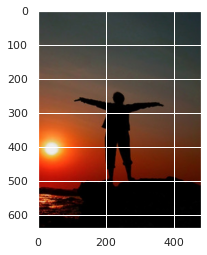

In [13]:
plt.imshow(image.load_img(np.random.choice(image_files)))

In [14]:
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top=False
)

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
x = Flatten()(ptm.output)

In [16]:
model = Model(inputs=ptm.input,outputs=x)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [18]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [19]:
batch_size=128

train_generator = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode='binary'
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode='binary'    
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

feat = model.predict(np.random.random([1]+ IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain,D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid,D))
Y_valid = np.zeros(Nvalid)

In [21]:
i = 0
for x,y in train_generator:
    features = model.predict(x)
    
    sz = len(y)
    
    X_train[i:i+sz] = features
    Y_train[i:i+sz] = y
    
    i += sz
    
    print(i)
    
    if i>= Ntrain:
        print('breaking now')
        break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [22]:
i = 0

for x,y in valid_generator:
    features = model.predict(x)
    
    sz = len(y)
    
    X_valid[i:i+sz] = features
    Y_valid[i:i+sz] = y
    
    i += sz
    
    if i >= Nvalid:
        print('breaking now')
        break
print(i)

breaking now
1000


In [23]:
X_train.max(), X_train.min()

(650.8261108398438, 0.0)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train2 =scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [25]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2,Y_train))
print(logr.score(X_valid,Y_valid))

1.0
0.979


In [29]:
i = Input(shape=(D,))
x = Dense(1, activation = 'sigmoid')(i)
linearmodel = Model(i,x)

In [30]:
linearmodel.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [31]:
r = linearmodel.fit(
    X_train, Y_train,
    batch_size = 128,
    epochs = 10,
    validation_data=(X_valid, Y_valid)
)

Epoch 1/10
24/24 [==============================] - 0s 15ms/step - loss: 1.2195 - accuracy: 0.9213 - val_loss: 0.0748 - val_accuracy: 0.9720
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0530 - accuracy: 0.9940 - val_loss: 0.0757 - val_accuracy: 0.9700
Epoch 3/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0751 - val_accuracy: 0.9690
Epoch 4/10
24/24 [==============================] - 0s 10ms/step - loss: 5.0581e-05 - accuracy: 1.0000 - val_loss: 0.0747 - val_accuracy: 0.9680
Epoch 5/10
24/24 [==============================] - 0s 10ms/step - loss: 2.1468e-05 - accuracy: 1.0000 - val_loss: 0.0746 - val_accuracy: 0.9680
Epoch 6/10
24/24 [==============================] - 0s 10ms/step - loss: 1.6102e-05 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 0.9680
Epoch 7/10
24/24 [==============================] - 0s 10ms/step - loss: 1.3315e-05 - accuracy: 1.0000 - val_loss: 0.0745 - val_accuracy: 0.9680

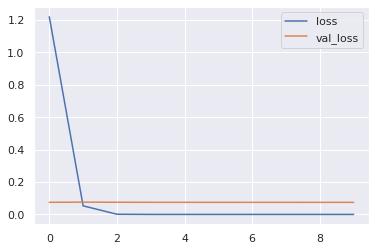

In [34]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

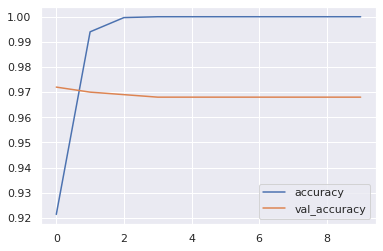

In [35]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()